## My 1st NN
## Digit Recognition using MNIST dataset
NN with one hidden sigma layer (50 neurons) and one softmax output layer.
I used MomentumOptimizer with 1.0 learning rate.
I started with 5.8 % accuracy and now it is almost 97 %. I'm sure I can do better, besides I didn't use convolutional layers and so on. However, my results are still quite good for me to be proud of myself ('cause it's my first time, remember it!).

In [1]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [91]:
import numpy as np
import  matplotlib.pyplot as plt
from numpy import random
from sklearn.metrics import confusion_matrix

In [3]:
from mnist import load_dataset

#[down]loading the original MNIST dataset.
#Please note that you should only train your NN on _train sample,
# _val can be used to evaluate out-of-sample error, compare models or perform early-stopping
# _test should be hidden under a rock untill final evaluation... But we both know it is near impossible to catch you evaluating on it.
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

(50000, 28, 28) (50000,)


In [4]:
x_train = X_train.reshape(50000, 784)
print(x_train.shape)
x_test = X_test.reshape(10000, 784)
print(x_test.shape)
x_val = X_val.reshape(10000, 784)
print(x_val.shape)

(50000, 784)
(10000, 784)
(10000, 784)


3


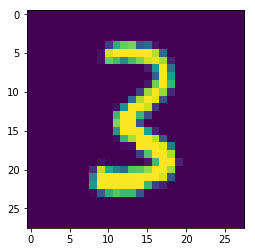

In [5]:
%matplotlib inline
a=random.randint(0,9999)
plt.imshow(x_val[0,:].reshape(28,28))
print(y_val[0])

In [48]:
hidden_size = 50 # Number of neurons in the hidden layer
batch_size = 500
nClasses = 10
nFeatures = 28*28

In [49]:
# create computation graph
W_hidden = tf.Variable(tf.truncated_normal([hidden_size, nFeatures, nClasses], stddev=0.1, dtype='float64'))
W_softmax = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.1,dtype='float64'))
b_hidden = tf.Variable(tf.truncated_normal([hidden_size, nClasses], stddev=0.1, dtype='float64'))
b_softmax = tf.Variable(tf.truncated_normal([nClasses], stddev=0.1, dtype='float64'))

input_X = tf.placeholder('float64', shape=[None,nFeatures])
input_y = tf.placeholder('float64', shape=[None, nClasses])

In [50]:
output_hidden = tf.sigmoid(tf.tensordot(input_X, W_hidden, [[-1],[-2]]) + b_hidden)
y_pred = tf.nn.softmax(tf.tensordot(W_softmax, output_hidden,[[-1],[-2]]) + b_softmax)

In [84]:
# evaluating loss and optimizer
loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=y_pred))
optimizer = tf.train.MomentumOptimizer(1.,0.9).minimize(loss, var_list = (W_hidden, W_softmax, b_hidden, b_softmax))

In [85]:
train_function = lambda x,y: (s.run([optimizer,loss], {input_y: y, input_X: x}))[1]# compile function that takes X and y, returns log loss and updates weights
predict_function = lambda x: s.run(y_pred, {input_X: x})# compile function that takes X and computes probabilities of y

In [53]:
# Yes, I took this function from github.com
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [54]:
y_true_train = dense_to_one_hot(y_train)
y_true_val = dense_to_one_hot(y_val)
y_true_test = dense_to_one_hot(y_test)
print(y_true_train.shape)

(50000, 10)


In [83]:
print(np.sum(y_true_train, axis=0))
print(np.sum(y_true_val, axis=0))
print(np.sum(y_true_test, axis=0))

[ 4932.  5678.  4968.  5101.  4859.  4506.  4951.  5175.  4842.  4988.]
[  991.  1064.   990.  1030.   983.   915.   967.  1090.  1009.   961.]
[  980.  1135.  1032.  1010.   982.   892.   958.  1028.   974.  1009.]


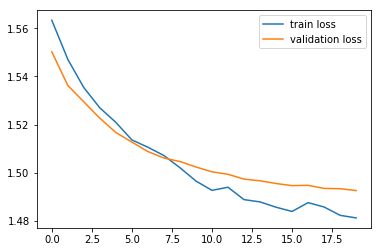

Wall time: 5min 26s


In [88]:
%%time
%matplotlib inline
# training  model
n = x_train.shape[0] // batch_size
# shufle indeces for training on random batches
indeces = np.arange(X_train.shape[0]) 
epochs = 20
loss_values = np.array([])
loss_val = np.array([])
loss_train = np.array([])
s.run(tf.global_variables_initializer())
for j in range(epochs):
    np.random.shuffle(indeces)
    for i in range(n):
        batch_ind = indeces[i*batch_size : (i+1)*batch_size]
        loss_i = train_function(x_train[batch_ind,:], y_true_train[batch_ind,:]) # train model and compute loss at iteration i
        loss_values = np.append(loss_values, loss_i)
    loss_train = np.append(loss_train, np.mean(loss_values[-20:]))
    loss_val = np.append(loss_val, s.run(loss, feed_dict={input_y: y_true_val, input_X : x_val}))

# Let's plot train loss and validation loss depending on the number of epochs.
# I tried from 1 to 50 epochs and I consider 20 to be enough and optimal
train_loss, = plt.plot(np.arange(epochs), loss_train, label='train loss')
val_loss, = plt.plot(np.arange(epochs), loss_val, label='validation loss')
plt.legend(handles=[train_loss, val_loss])
plt.show()                                  


0.9703


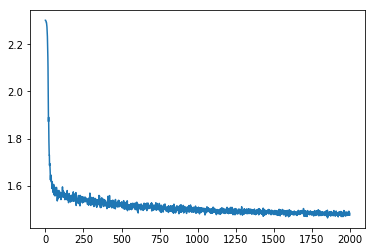

In [89]:
# validation
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(input_y, axis=1)), dtype='float32'))
print(s.run(accuracy, feed_dict={input_y : y_true_val, input_X : x_val}))
%matplotlib inline
steps = np.arange(epochs*n)
#plt.xlim()
plt.plot(steps, loss_values)

In [115]:
# predict & evaluate on test
y_pred_test = s.run(tf.argmax(y_pred,axis=1), feed_dict={input_y: y_true_test, input_X : x_test})
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(input_y, axis=1)), dtype='float32'))
print(s.run(accuracy, feed_dict={input_y : y_true_test, input_X : x_test}))


0.9684


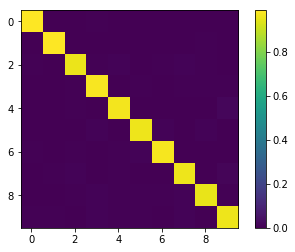

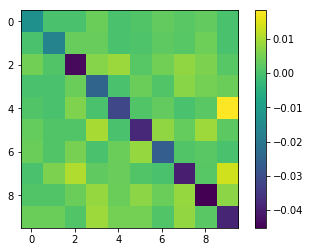

In [146]:
# confusion matrix 
%matplotlib inline
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.imshow(cm_norm)
plt.colorbar()
plt.show()
# To see more details let's subtract the unit matrix
E = np.eye(10)
plt.imshow(cm_norm - E)
plt.colorbar()
plt.show()

Recognized: 2


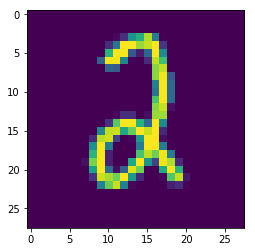

In [141]:
a = np.random.randint(9999)
print("Recognized:",y_pred_test[a])
plt.imshow(X_test[a])

In [ ]:
# How to change values of variables by indeces
#shape = [1,2,3]
#indices = [[1, 1, 2], [2,1,2]]
#values = [1.0,2.0]
#delta = tf.SparseTensor(indices, values, shape)
#t = t + tf.sparse_tensor_to_dense(delta)